# Synthesis Algorithms
- Split Det (sd) = translate to tgba, split, then determinize
- Det Split (ds) = translate to tgba, determinize, then split
- DPA Split (ps) = translate to dpa, then split
- LAR = translate to a deterministic automaton with arbitrar acceptance condition, then use LAR to turn to parity, then split (default)

In [1]:
from dataclasses import dataclass
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import re

# Loading Data

## Synt Tools Loading

In [2]:
@dataclass
class BenchmarkResult:
    benchmark_name: str
    tool: str
    total_durations: int # In milliseconds
    is_realizable: bool
    total_states: int
    is_completed: bool

    @staticmethod
    def read_from_hoa(hoa_filepath: str):
        hoa = Path(hoa_filepath).read_text()
        
        total_duration_rgx = "Total Duration:\s*(\d+[.]?\d*)"
        tool_name_rgx = "Tool:\s*(.*)[*][/]"
        total_states_rgx = "States:\s*(\d+)"
        benchmark_name = Path(hoa_filepath).stem
        
        is_completed = ("REALIZABLE" in hoa) or ("UNREALIZABLE" in hoa)
        total_duration = float(re.search(total_duration_rgx, hoa).group(1))
        tool_name = re.search(tool_name_rgx, hoa).group(1)
        
        is_realizable = not("UNREALIZABLE" in hoa) if is_completed else None
        total_states = re.search(total_states_rgx, hoa).group(1) if is_realizable else None
    
        return BenchmarkResult(
            benchmark_name, tool_name.strip(), total_duration,
            is_realizable, total_states, is_completed
        )

In [3]:
algorithms_output_path = glob("../assets/synthesis-outputs/*")
algorithms = [ Path(path).stem for path in algorithms_output_path]

In [4]:
algorithms_benchmarks = {}
for algo, outputs_path in zip(algorithms, algorithms_output_path):
    benchmarks_path = glob(f"{outputs_path}/*")
    benchmarks = [ BenchmarkResult.read_from_hoa(benchmark) for benchmark in benchmarks_path]
    algorithms_benchmarks[algo] = benchmarks

In [5]:
all_benchmarks_dict = []
for algo, benchmarks in algorithms_benchmarks.items():
    for benchmark in benchmarks:
        all_benchmarks_dict.append(benchmark.__dict__)
benchmarks_df = pd.DataFrame(all_benchmarks_dict)
benchmarks_df.head()

,benchmark_name,tool,total_durations,is_realizable,total_states,is_completed
0,TwoCountersInRangeA4,bfss-synt,292.662,False,None,True
1,ltl2dba05,bfss-synt,59.119,True,12,True
2,ltl2dba11,bfss-synt,18.899,True,4,True
3,TwoCountersDisButA6,bfss-synt,11004.737,False,None,True
4,TorcsSteeringSimple,bfss-synt,48.283,True,1,True


In [6]:
# Removing total duration from incompleted benchmarks
benchmarks_df.loc[benchmarks_df["is_completed"] == False, "total_durations"] = None

In [7]:
tools_list = benchmarks_df["tool"].unique()
print("Tool list: ", tools_list)

Tool list:  ['bfss-synt' 'ltlsynt-ds' 'ltlsynt-sd' 'ltlsynt-lar' 'ltlsynt-ps']


## Deps Loading

In [8]:
find_deps_df = pd.read_csv('../assets/find_deps_by_automaton_summary.csv', index_col=0)
find_deps_df.head()

,name,total_inputs,total_outputs,is_completed,automaton_build_duration,is_automaton_built,find_deps_duration,total_dependent_vars,dependency_ratio,input_vars,output_vars,dependent_vars,independent_vars,untested_vars,total_duration
0,ltl2dpa20,3,2,True,33.0,True,2.0,1,0.500000,"['c', 'b', 'a']","['p1', 'p0']",['p0'],['p1'],[],35
1,TwoCountersInRangeA2,11,8,True,7728.0,True,7.0,3,0.375000,"['p0p0second0selected', 'p0p0in2range0f1dincre...","['u0selected0f1dtoggle0selected1b', 'u0selecte...","['u0first2counter0first2counter', 'u0second2co...",['u0first2counter0f1ddecrement0first2counter1b...,[],7735
2,lilydemo24,4,4,True,21.0,True,1.0,0,0.000000,"['r2b_ack1', 'r2b_ack0', 's2b_req1', 's2b_req0']","['b2r_req1', 'b2r_req0', 'b2s_ack1', 'b2s_ack0']",[],"['b2s_ack0', 'b2s_ack1', 'b2r_req0', 'b2r_req1']",[],22
3,OneCounterGuiA9,9,9,True,15417.0,True,11.0,3,0.333333,"['p0p0in2range0f1dinc0f1dinc0counter1b1b', 'p0...","['u0counter0f1dinc0counter1b', 'u0counter0f1dd...","['u0button2down0button2down', 'u0button2up0but...","['u0button2down0f1ddisable1b', 'u0button2down0...",[],15428
4,ltl2dba24,1,1,True,8.0,True,0.0,0,0.000000,['p'],['acc'],[],['acc'],[],8


In [9]:
find_deps_df.loc[find_deps_df["is_completed"] == False, "total_duration"] = None

In [10]:
hoa = Path("../assets/synthesis-outputs/bfss-synt/ltl2dpa18.hoa").read_text()
re.search("[/][*]\s*Synthesis Measures:\s*\n(.*)\n[*][/]", hoa).group(1)

'{"is_completed":true,"output_vars":["p1","p0"],"algorithm_type":"automaton","input_vars":["c","b","a"],"formula":"G(p0 <-> !p1) & (GFp0 <-> (Gb | (G(b | FGa) & G(c | FG!a)) | Gc))","total_time":28,"automaton":{"is_built":true,"build_duration":7,"total_states":23,"state_based_status":"true"},"tested_variables":[{"name":"p0","duration":6,"is_dependent":true,"tested_dependency_set":["c","b","a","p1"]},{"name":"p1","duration":0,"is_dependent":false,"tested_dependency_set":["c","b","a"]}],"algorithm":{"type":"automaton","total_pair_state":146,"search_pair_state_duration":3,"prune_automaton_duration":0,"pruned_state_based_status":"true","prune_total_states":23},"synthesis_process":{"remove_dependent_ap_duration":0,"split_2step_duration":0,"nba_to_dpa_duration":3,"solve_game_duration":0,"dpa_to_mealy_duration":0}}'

## Sanity Check

All benchmarks realizabliity are same in all synthesis tools

In [11]:
benchs_by_tool = benchmarks_df.pivot(index="benchmark_name", columns="tool", values=["is_realizable", "is_completed"]).copy()
benchs_by_tool["is_different"] = benchs_by_tool["is_realizable"].apply(lambda x: x.nunique() > 1, axis=1)
benchs_by_tool[benchs_by_tool["is_different"] == True]

Empty DataFrame
Columns: [(is_realizable, bfss-synt), (is_realizable, ltlsynt-ds), (is_realizable, ltlsynt-lar), (is_realizable, ltlsynt-ps), (is_realizable, ltlsynt-sd), (is_completed, bfss-synt), (is_completed, ltlsynt-ds), (is_completed, ltlsynt-lar), (is_completed, ltlsynt-ps), (is_completed, ltlsynt-sd), (is_different, )]
Index: []

What was completed in find deps but in synthesis and vice versa

In [12]:
dependents_benchmarks_df = pd.merge(
    benchmarks_df[benchmarks_df["tool"] == "bfss-synt"][["benchmark_name", "is_completed"]],
    find_deps_df[["name", "is_completed"]],
    left_on="benchmark_name",
    right_on="name",
    suffixes=("_synthesis", "_find_deps")
)
dependents_benchmarks_df[
    dependents_benchmarks_df["is_completed_synthesis"] != dependents_benchmarks_df["is_completed_find_deps"]
]

,benchmark_name,is_completed_synthesis,name,is_completed_find_deps
3,TwoCountersDisButA6,True,TwoCountersDisButA6,False
6,TwoCountersDisButA7,True,TwoCountersDisButA7,False
13,TwoCountersDisButAC,True,TwoCountersDisButAC,False
89,lilydemo18,False,lilydemo18,True
113,LedMatrix,True,LedMatrix,False
128,SPIPureNext,True,SPIPureNext,False
153,Gamelogic,True,Gamelogic,False
154,KitchenTimerV9,True,KitchenTimerV9,False
179,TwoCountersDisButA9,True,TwoCountersDisButA9,False
188,TwoCountersDisButA8,True,TwoCountersDisButA8,False


In [13]:
synt_tools_duration = benchmarks_df.pivot(index='benchmark_name', columns='tool', values='total_durations').copy()
synt_tools_duration

tool,bfss-synt,ltlsynt-ds,ltlsynt-lar,ltlsynt-ps,ltlsynt-sd
benchmark_name,,,,,
01,28.062,41.985,45.017,30.460,572.161
02,158.667,182.685,195.205,195.194,NaN
03,6914.111,26902.344,61097.445,60944.600,NaN
05,NaN,1651868.074,2073657.521,1997374.362,NaN
06,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
ltl2dpa20,63.420,55.793,31.733,28.385,38.255
ltl2dpa21,39.317,66.278,43.697,288.678,580.302
ltl2dpa22,167152.636,554794.098,44.972,32.035,96325.979


# Benchmarks

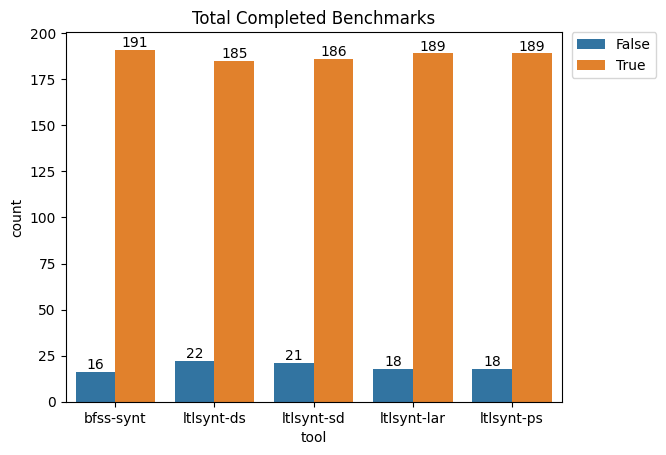

In [14]:
ax = sns.countplot(x="tool", data=benchmarks_df, hue="is_completed")
for container in ax.containers: ax.bar_label(container)
ax.set_title("Total Completed Benchmarks")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [15]:
find_deps_tool = find_deps_df[["name","total_duration","total_dependent_vars","dependency_ratio"]].copy()
find_deps_tool.rename(columns={"name": "benchmark_name", "total_duration": "find-deps"}, inplace=True)

tools_comparastion_df = pd.merge(synt_tools_duration, find_deps_tool, on="benchmark_name", how="outer")
tools_comparastion_df["max"] =  tools_comparastion_df[tools_list].idxmax(axis=1)
tools_comparastion_df["min"] =  tools_comparastion_df[tools_list].idxmin(axis=1)
tools_comparastion_df.head()

,benchmark_name,bfss-synt,ltlsynt-ds,ltlsynt-lar,ltlsynt-ps,ltlsynt-sd,find-deps,total_dependent_vars,dependency_ratio,max,min
0,01,28.062,41.985,45.017,30.460,572.161,68.0,0.0,0.0,ltlsynt-sd,bfss-synt
1,02,158.667,182.685,195.205,195.194,NaN,629.0,0.0,0.0,ltlsynt-lar,bfss-synt
2,03,6914.111,26902.344,61097.445,60944.600,NaN,70463.0,0.0,0.0,ltlsynt-lar,bfss-synt
3,05,NaN,1651868.074,2073657.521,1997374.362,NaN,NaN,NaN,NaN,ltlsynt-lar,ltlsynt-ds
4,06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


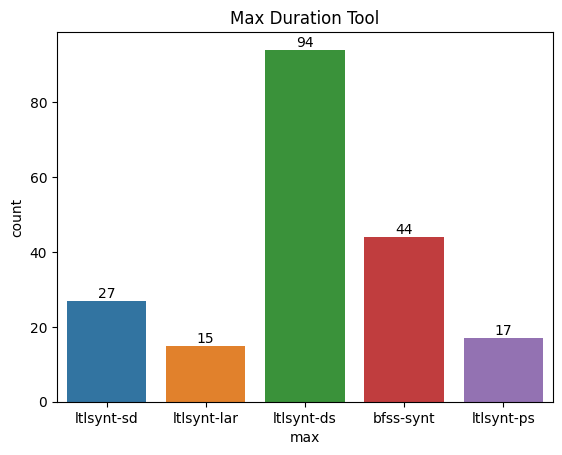

In [16]:
ax = sns.countplot(x="max", data=tools_comparastion_df)
for container in ax.containers: ax.bar_label(container)
ax.set_title("Max Duration Tool");

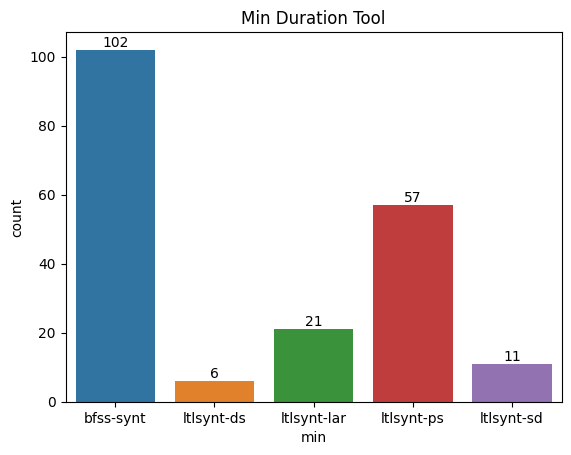

In [17]:
ax = sns.countplot(x="min", data=tools_comparastion_df)
for container in ax.containers: ax.bar_label(container)
ax.set_title("Min Duration Tool");

* **TODO:** What's the relationship between dependent variables to synthesis process?
* **TODO:** Compare the different in number of states between the benchmarks